In [1]:
import keras
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from time import time
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image, ImageFile

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
vggmodel = keras.applications.vgg16.VGG16()
newmodel = Sequential() 
num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False

553467904/553467096 [==============================] - 36s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
____________________________________________________

NameError: ignored

In [4]:
PATH_TRAIN = r'gdrive/My Drive/colourisation/Train'


In [5]:
X =[]
Y =[]
for img in os.listdir(PATH_TRAIN):
  try:
      p=os.path.join(PATH_TRAIN,img)
      img=load_img(p,target_size=(224,224 ,3))
      img=img_to_array(img)

      img=img/256
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128)
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
print(X.shape)

(2110, 224, 224)


In [6]:
X = X.reshape(X.shape+(1,))

In [7]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(2110, 7, 7, 512)


In [8]:
#Encoder
encoder_input = Input(shape=(7, 7, 512,))
#Decoder
decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_input)
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)

In [9]:
from keras.callbacks import TensorBoard

model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=100, batch_size=128)

Epoch 1/100
2110/2110 [==============================] - 5s 2ms/step - loss: 0.1940 - accuracy: 0.5011
Epoch 2/100
2110/2110 [==============================] - 3s 1ms/step - loss: 0.0145 - accuracy: 0.5797
Epoch 3/100
2110/2110 [==============================] - 3s 1ms/step - loss: 0.0133 - accuracy: 0.5890
Epoch 4/100
2110/2110 [==============================] - 3s 1ms/step - loss: 0.0131 - accuracy: 0.5980
Epoch 5/100
2110/2110 [==============================] - 3s 1ms/step - loss: 0.0130 - accuracy: 0.5997
Epoch 6/100
2110/2110 [==============================] - 3s 1ms/step - loss: 0.0128 - accuracy: 0.5994
Epoch 7/100
2110/2110 [==============================] - 3s 1ms/step - loss: 0.0126 - accuracy: 0.5956
Epoch 8/100
2110/2110 [==============================] - 3s 1ms/step - loss: 0.0123 - accuracy: 0.5966
Epoch 9/100
2110/2110 [==============================] - 3s 1ms/step - loss: 0.0121 - accuracy: 0.5977
Epoch 10/100
2110/2110 [==============================] - 3s 1ms/step - l

In [11]:
testpath = r'gdrive/My Drive/colourisation/Test'
import matplotlib.pyplot as plt

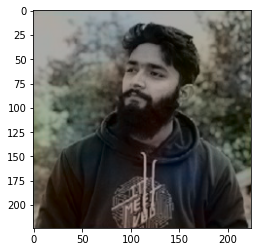

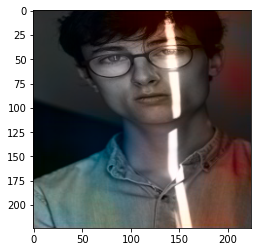

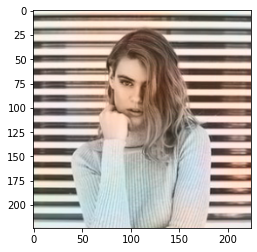

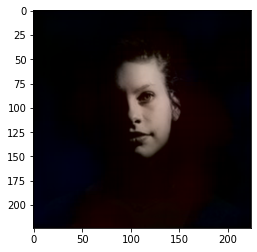

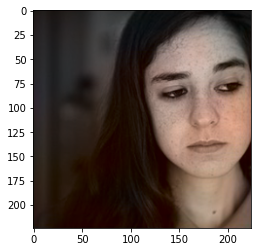

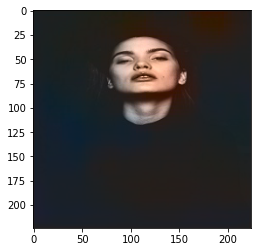

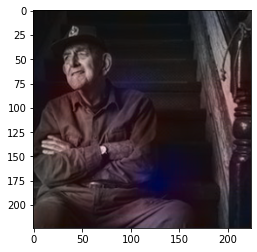

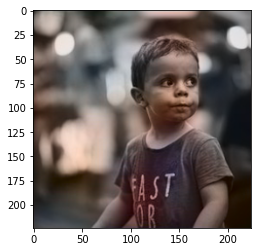

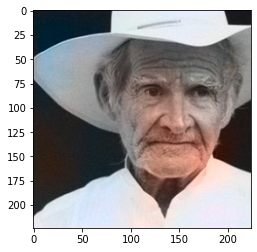

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


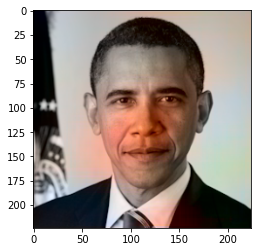

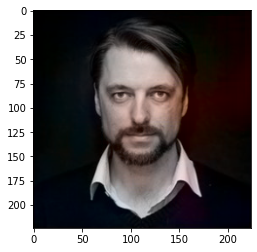

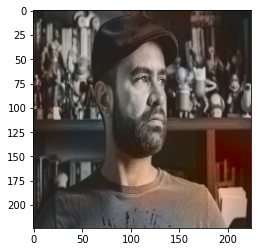

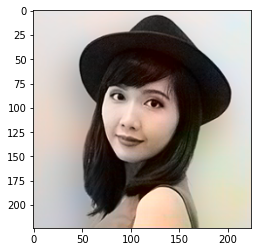

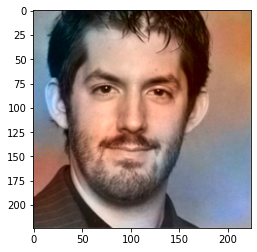

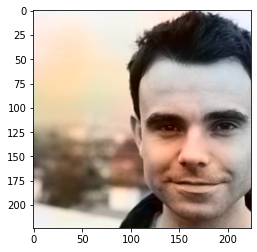

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 25 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


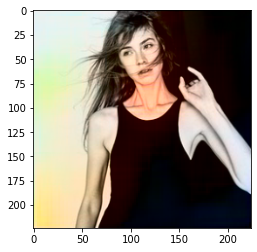

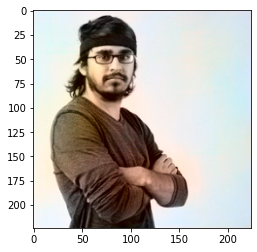

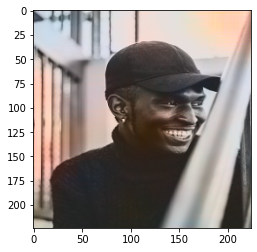

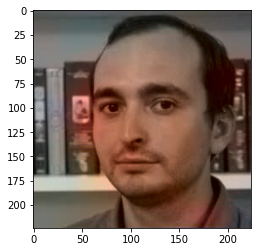

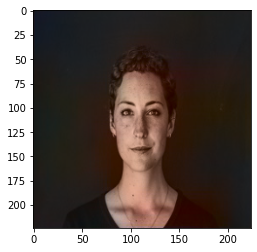

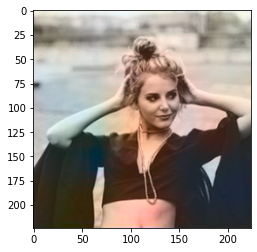

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 173 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


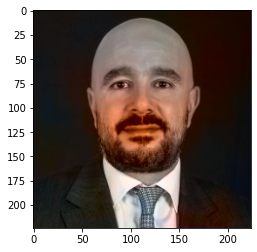

In [12]:

files = os.listdir(testpath)
for idx, file in enumerate(files):
    test = img_to_array(load_img(os.path.join(testpath,file)))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    #print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    plt.imshow(lab2rgb(cur))
    plt.show()